In [3]:
import pandas as pd
from bgreference import refseq
import numpy as np
import sys, os, json
from scipy import stats
from tqdm import tqdm
import scipy.stats as st
import statistics 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib.lines import Line2D
import random
import matplotlib.patches as patches

In [4]:
dfpp = pd.read_csv("data/unpairs/NC_045512.2.maxBPspan250.noTetra.fold.pp.tsv", sep="\t", header=None, names=["pos", "ref", "ann"]) 
#dfpp = pd.read_csv("data/unpairs/NC_045512.2.maxBPspan250.noTetra.fold.pp_original.tsv", sep="\t", header=None, names=["pos", "ref", "ann"]) 
print("Paired (#paired/TOTAL): "+str(len(dfpp[(dfpp["ann"]=="paired")])/len(dfpp)))
print("Unpaired (#unpaired/TOTAL): "+str(len(dfpp[(dfpp["ann"]=="unpaired")])/len(dfpp)))
print(dfpp)

spacesize=[]
for index, row in tqdm(dfpp[:-1].sort_values('pos').iterrows(), total=dfpp.shape[0]):
    #all except last line
    incre = 0
    ann = "unpaired"
    while ann == "unpaired":
        incre +=1
        if not (dfpp.loc[dfpp['pos']==(row['pos']+incre), "ann"]).empty:
            ann = dfpp.loc[dfpp['pos']==(row['pos']+incre), "ann"].item()
        else:
            ann = "paired"
    spacesize.append(incre-1)

spacesize.append(0)
dfpp['spacesize']=spacesize

print(dfpp)

  0%|          | 43/29903 [00:00<01:09, 427.32it/s]

Paired (#paired/TOTAL): 0.6433802628498813
Unpaired (#unpaired/TOTAL): 0.35661973715011874
         pos ref       ann
0          1   A  unpaired
1          2   U  unpaired
2          3   U  unpaired
3          4   A  unpaired
4          5   A  unpaired
...      ...  ..       ...
29898  29899   A  unpaired
29899  29900   A  unpaired
29900  29901   A  unpaired
29901  29902   A  unpaired
29902  29903   A  unpaired

[29903 rows x 3 columns]


100%|█████████▉| 29902/29903 [00:53<00:00, 559.70it/s]

         pos ref       ann  spacesize
0          1   A  unpaired          5
1          2   U  unpaired          4
2          3   U  unpaired          3
3          4   A  unpaired          2
4          5   A  unpaired          1
...      ...  ..       ...        ...
29898  29899   A  unpaired          4
29899  29900   A  unpaired          3
29900  29901   A  unpaired          2
29901  29902   A  unpaired          1
29902  29903   A  unpaired          0

[29903 rows x 4 columns]


In [5]:
def coronavirus(pos, size=1):
    return refseq("sarscov2", "0", pos, size)

def load_signature_dictionary (fjson):
    with open(fjson) as json_file: 
        return json.load(json_file) 

def get_observed_synmutation_count():
    df = pd.read_csv("data/inter/SARS-CoV-2-project.csv",sep="\t")
    #df=df[~df["csqn_type"].isin(["stop_gained","missense_variant","start_lost"])]
    #To avoid empty csqn_type (indels)
    df=df[df["csqn_type"].isin(["upstream_gene_variant","downstream_gene_variant","synonymous_variant"])]   
    list_positions = df["pos"].values
    #return np.unique(list_positions)
    return list_positions

def get_observed_mutation_count():
    df = pd.read_csv("data/inter/SARS-CoV-2-project.csv",sep="\t")
    #To avoid empty csqn_type (indels)
    df=df[df["csqn_type"].isin(["upstream_gene_variant","downstream_gene_variant","synonymous_variant","stop_gained","missense_variant","start_lost"])]   
    list_positions = df["pos"].values
    #return np.unique(list_positions)
    return list_positions

def get_observed_ntmutation_count(ref,alt):
    df = pd.read_csv("data/inter/SARS-CoV-2-project.csv",sep="\t")
    #To avoid empty csqn_type (indels)
    df=df[df["csqn_type"].isin(["upstream_gene_variant","downstream_gene_variant","synonymous_variant","stop_gained","missense_variant","start_lost"])]   
    df=df[(df["ref"]==ref) & (df["alt"]==alt)]
    list_positions = df["pos"].values
    #return np.unique(list_positions)
    return list_positions

def get_observed_ntsynmutation_count(ref,alt):
    df = pd.read_csv("data/inter/SARS-CoV-2-project.csv",sep="\t")
    #To avoid empty csqn_type (indels)
    df=df[df["csqn_type"].isin(["upstream_gene_variant","downstream_gene_variant","synonymous_variant"])]   
    df=df[(df["ref"]==ref) & (df["alt"]==alt)]
    list_positions = df["pos"].values
    #return np.unique(list_positions)
    return list_positions

def count_unpairedmutation_chunk(start, lmuta, csize):
    #Given a list of mutations, count how many unpaired there are.
    mutaunpair = dfpp[dfpp['pos'].isin(lmuta)]
    return len(mutaunpair[(mutaunpair["ann"]=="unpaired") & (mutaunpair["pos"] >= start) & (mutaunpair["pos"] <= (start+csize))])
    #return len(mutaunpair[(mutaunpair["ann"]=="unpaired")])

def count_unpairedSpacemutation_chunk(start, lmuta, csize):
    #Given a list of mutations, count how many unpaired there are.
    mutaunpair = dfpp[dfpp['pos'].isin(lmuta)]
    return len(mutaunpair[(mutaunpair["spacesize"]>3) & (mutaunpair["pos"] >= start) & (mutaunpair["pos"] <= (start+csize))])
    
#list of homoplasy positions
dfplas = pd.read_csv("data/GISAID_homoplasy_Mask.txt",sep="\t") 
dfplas = dfplas[['position_Start']]

N=10**4
start_position = 2
last_position = 29902
bases = set(["A","C","T","G"])
chunk_size = 29902

In [11]:
#SYN
jsfile="data/prob_syn_full_genome.json"

simulated_probs = []
simulated_position = []
observed_mutations = get_observed_synmutation_count() # Get observed mutations to simulate
N_observed_mutations = len(observed_mutations)
print("Observed non-protein affecting mutations: "+str(N_observed_mutations))
d_signature = load_signature_dictionary(jsfile)

dfsyn = pd.read_csv("data/annotated_mutations_VEP.tsv",sep="\t") 
dfsyn=dfsyn[dfsyn["csqn_type"].isin(["upstream_gene_variant","downstream_gene_variant","synonymous_variant"])]
dfsyn = dfsyn[['pos', 'ref', 'alt']]

#list of mutations and probs.
for position in range(start_position,last_position+1,1): # Iterate over the virus genome
    ref_triplet = coronavirus(position-1,3)
    ref = ref_triplet[1]
    alts =  bases - set(ref)
    for alt in alts: # for each possible mutation of the base
        if not dfsyn[(dfsyn.pos==position)&(dfsyn.ref==ref)&(dfsyn.alt==alt)].empty and (position not in dfplas and position >55 and position < 29804):
                #syn
                prob = d_signature[ref_triplet+"_"+alt]
                simulated_probs.append(prob)
        else:
            #nonsyn
            simulated_probs.append(0)
        simulated_position.append(position)

# Normalize simulated probabilities
simulated_probs = list(map(lambda x: x/sum(simulated_probs), simulated_probs))

#simulated_position #array of positions
background = np.random.choice(simulated_position, size=(N, N_observed_mutations), p=simulated_probs, replace=True)

list_results = []
idchunk=0
for startp in tqdm(range (0,last_position,chunk_size)):
    observed_unpairedcount_chunk=count_unpairedmutation_chunk(startp, observed_mutations, chunk_size)
    # Now the simulated
    chunk_simulation = []
    for simulation in background:
        chunk_simulation.append(count_unpairedmutation_chunk(startp, simulation ,chunk_size))
    mean_count_simulated = np.nanmean(chunk_simulation) # This is the mean number of simulated mutations in the chunk! let's compare it with the observed ones
    #confidence interval
    (cih,cil) = st.t.interval(0.95, len(chunk_simulation)-1, loc=np.mean(chunk_simulation), scale=st.sem(chunk_simulation))
    std=np.std(chunk_simulation)
    a = observed_unpairedcount_chunk
    b = N_observed_mutations - observed_unpairedcount_chunk
    c = mean_count_simulated
    d = N_observed_mutations - mean_count_simulated  
    if a > 0:
        odds_ratio = (a/b) / (c/d)
        u,p_value = stats.power_divergence(f_obs=[a, b], f_exp=[c, d], lambda_="log-likelihood") # perform g-test
        list_results.append([startp,startp+chunk_size,idchunk, observed_unpairedcount_chunk, mean_count_simulated, odds_ratio, u, p_value, cil, cih, std]) # save results
    idchunk+=1
    
df_results = pd.DataFrame(list_results,columns=["start_chunk","end_chunk","id_chunk","unpaired_observed","mean_simulated","odds_ratio","u","pvalue", "cintervL", "cintervH","stdev"]) 
df_results
#df_results.to_csv(outfile,sep="\t",index=False)

Observed non-protein affecting mutations: 3314


100%|██████████| 1/1 [00:20<00:00, 20.96s/it]


,start_chunk,end_chunk,id_chunk,unpaired_observed,mean_simulated,odds_ratio,u,pvalue,cintervL,cintervH,stdev
0,0,29902,0,812,801.7298,1.016967,0.173046,0.677419,802.109419,801.350181,19.365355


In [12]:
#SYN & nonSYN
jsfile="data/prob_syn_full_genome.json"

simulated_probs = []
simulated_position = []
observed_mutations = get_observed_mutation_count() # Get observed mutations to simulate
N_observed_mutations = len(observed_mutations)
print("Observed mutations: "+str(N_observed_mutations))
d_signature = load_signature_dictionary(jsfile)

#list of mutations and probs.
for position in range(start_position,last_position+1,1): # Iterate over the virus genome
    ref_triplet = coronavirus(position-1,3)
    ref = ref_triplet[1]
    alts =  bases - set(ref)
    for alt in alts: # for each possible mutation of the base
        if (position not in dfplas and position >55 and position < 29804):
                #syn & nonsyn
                prob = d_signature[ref_triplet+"_"+alt]
                simulated_probs.append(prob)
        else:
            #homoplasy
            simulated_probs.append(0)
        simulated_position.append(position)

# Normalize simulated probabilities
simulated_probs = list(map(lambda x: x/sum(simulated_probs), simulated_probs))

#simulated_position #array of positions
background = np.random.choice(simulated_position, size=(N, N_observed_mutations), p=simulated_probs, replace=True) 

list_results = []
idchunk=0

for startp in tqdm(range (0,last_position,chunk_size)):
    observed_unpairedcount_chunk=count_unpairedmutation_chunk(startp, observed_mutations, chunk_size)
    # Now the simulated
    chunk_simulation = []
    for simulation in background:
        chunk_simulation.append(count_unpairedmutation_chunk(startp, simulation, chunk_size))
    mean_count_simulated = np.nanmean(chunk_simulation) # This is the mean number of simulated mutations in the chunk! let's compare it with the observed ones
    #confidence interval
    (cih,cil) = st.t.interval(0.95, len(chunk_simulation)-1, loc=np.mean(chunk_simulation), scale=st.sem(chunk_simulation))
    std=np.std(chunk_simulation)
    a = observed_unpairedcount_chunk
    b = N_observed_mutations - observed_unpairedcount_chunk
    c = mean_count_simulated
    d = N_observed_mutations - mean_count_simulated  
    if a > 0:
        odds_ratio = (a/b) / (c/d)
        u,p_value = stats.power_divergence(f_obs=[a, b], f_exp=[c, d], lambda_="log-likelihood") # perform g-test
        list_results.append([startp,startp+chunk_size,idchunk, observed_unpairedcount_chunk, mean_count_simulated, odds_ratio, u, p_value, cil, cih, std]) # save results
    idchunk+=1
    
df_results_all = pd.DataFrame(list_results,columns=["start_chunk","end_chunk","id_chunk","unpaired_observed","mean_simulated","odds_ratio","u","pvalue", "cintervL", "cintervH","stdev"]) 
df_results_all
#df_results.to_csv(outfile,sep="\t",index=False)

Observed mutations: 7908


100%|██████████| 1/1 [00:25<00:00, 25.59s/it]


,start_chunk,end_chunk,id_chunk,unpaired_observed,mean_simulated,odds_ratio,u,pvalue,cintervL,cintervH,stdev
0,0,29902,0,1961,1989.1677,0.98117,0.534604,0.464678,1989.786684,1988.548716,31.575984


In [13]:
#SYN & nonSYN, ONLY C>T
jsfile="data/prob_syn_full_genome.json"
ntref="C"
ntalt="T"

simulated_probs = []
simulated_position = []
observed_mutations = get_observed_ntmutation_count(ntref,ntalt) # Get observed mutations to simulate
N_observed_mutations = len(observed_mutations)
print("Observed "+ ntref +">"+ ntalt +" mutations: "+str(N_observed_mutations))
d_signature = load_signature_dictionary(jsfile)

#list of mutations and probs.
for position in range(start_position,last_position+1,1): # Iterate over the virus genome
    ref_triplet = coronavirus(position-1,3)
    ref = ref_triplet[1]
    alts =  bases - set(ref)
    for alt in alts: # for each possible mutation of the base
        if (ref=="C" and alt == "T") and (position not in dfplas and position >55 and position < 29804):
                #syn & nonsyn C>T
                prob = d_signature[ref_triplet+"_"+alt]
                simulated_probs.append(prob)
        else:
            #homoplasy and everything else
            simulated_probs.append(0)
        simulated_position.append(position)

# Normalize simulated probabilities
simulated_probs = list(map(lambda x: x/sum(simulated_probs), simulated_probs))
            
#simulated_position #array of positions
background = np.random.choice(simulated_position, size=(N, N_observed_mutations), p=simulated_probs, replace=True) 

list_results = []
idchunk=0

for startp in tqdm(range (0,last_position,chunk_size)):
    observed_unpairedcount_chunk=count_unpairedmutation_chunk(startp, observed_mutations, chunk_size)
    # Now the simulated
    chunk_simulation = []
    for simulation in background:
        chunk_simulation.append(count_unpairedmutation_chunk(startp, simulation, chunk_size))
    mean_count_simulated = np.nanmean(chunk_simulation) # This is the mean number of simulated mutations in the chunk! let's compare it with the observed ones
    #confidence interval
    (cih,cil) = st.t.interval(0.95, len(chunk_simulation)-1, loc=np.mean(chunk_simulation), scale=st.sem(chunk_simulation))
    std=np.std(chunk_simulation)
    a = observed_unpairedcount_chunk
    b = N_observed_mutations - observed_unpairedcount_chunk
    c = mean_count_simulated
    d = N_observed_mutations - mean_count_simulated  
    if a > 0:
        odds_ratio = (a/b) / (c/d)
        u,p_value = stats.power_divergence(f_obs=[a, b], f_exp=[c, d], lambda_="log-likelihood") # perform g-test
        list_results.append([startp,startp+chunk_size,idchunk, observed_unpairedcount_chunk, mean_count_simulated, odds_ratio, u, p_value, cil, cih, std]) # save results
    idchunk+=1
    
df_results_all = pd.DataFrame(list_results,columns=["start_chunk","end_chunk","id_chunk","unpaired_observed","mean_simulated","odds_ratio","u","pvalue", "cintervL", "cintervH","stdev"]) 
df_results_all
#df_results.to_csv(outfile,sep="\t",index=False)

Observed C>T mutations: 3513


100%|██████████| 1/1 [00:21<00:00, 21.48s/it]


,start_chunk,end_chunk,id_chunk,unpaired_observed,mean_simulated,odds_ratio,u,pvalue,cintervL,cintervH,stdev
0,0,29902,0,869,880.7982,0.982203,0.21155,0.645555,881.160885,880.435515,18.501521


In [14]:
#SYN & nonSYN, ONLY C>T. Unpair strict
jsfile="data/prob_syn_full_genome.json"
ntref="C"
ntalt="T"

simulated_probs = []
simulated_position = []
observed_mutations = get_observed_ntmutation_count(ntref,ntalt) # Get observed mutations to simulate
N_observed_mutations = len(observed_mutations)
print("Observed "+ ntref +">"+ ntalt +" mutations: "+str(N_observed_mutations))
d_signature = load_signature_dictionary(jsfile)

#list of mutations and probs.
for position in range(start_position,last_position+1,1): # Iterate over the virus genome
    ref_triplet = coronavirus(position-1,3)
    ref = ref_triplet[1]
    alts =  bases - set(ref)
    for alt in alts: # for each possible mutation of the base
        if (ref=="C" and alt == "T") and (position not in dfplas and position >55 and position < 29804):
                #syn & nonsyn C>T
                prob = d_signature[ref_triplet+"_"+alt]
                simulated_probs.append(prob)
        else:
            #homoplasy and everything else
            simulated_probs.append(0)
        simulated_position.append(position)

# Normalize simulated probabilities
simulated_probs = list(map(lambda x: x/sum(simulated_probs), simulated_probs))
            
#simulated_position #array of positions
background = np.random.choice(simulated_position, size=(N, N_observed_mutations), p=simulated_probs, replace=True) 

list_results = []
idchunk=0

for startp in tqdm(range (0,last_position,chunk_size)):
    observed_unpairedcount_chunk=count_unpairedmutation_chunk(startp, observed_mutations, chunk_size)
    # Now the simulated
    chunk_simulation = []
    for simulation in background:
        chunk_simulation.append(count_unpairedmutation_chunk(startp, simulation, chunk_size))
    mean_count_simulated = np.nanmean(chunk_simulation) # This is the mean number of simulated mutations in the chunk! let's compare it with the observed ones
    #confidence interval
    (cih,cil) = st.t.interval(0.95, len(chunk_simulation)-1, loc=np.mean(chunk_simulation), scale=st.sem(chunk_simulation))
    std=np.std(chunk_simulation)
    a = observed_unpairedcount_chunk
    b = N_observed_mutations - observed_unpairedcount_chunk
    c = mean_count_simulated
    d = N_observed_mutations - mean_count_simulated  
    if a > 0:
        odds_ratio = (a/b) / (c/d)
        u,p_value = stats.power_divergence(f_obs=[a, b], f_exp=[c, d], lambda_="log-likelihood") # perform g-test
        list_results.append([startp,startp+chunk_size,idchunk, observed_unpairedcount_chunk, mean_count_simulated, odds_ratio, u, p_value, cil, cih, std]) # save results
    idchunk+=1
    
df_results_all = pd.DataFrame(list_results,columns=["start_chunk","end_chunk","id_chunk","unpaired_observed","mean_simulated","odds_ratio","u","pvalue", "cintervL", "cintervH","stdev"]) 
df_results_all
#df_results.to_csv(outfile,sep="\t",index=False)

Observed C>T mutations: 3513


100%|██████████| 1/1 [00:21<00:00, 21.50s/it]


,start_chunk,end_chunk,id_chunk,unpaired_observed,mean_simulated,odds_ratio,u,pvalue,cintervL,cintervH,stdev
0,0,29902,0,869,881.0808,0.981782,0.221774,0.637692,881.441017,880.720583,18.375611


In [15]:
#SYN ONLY C>T. Unpair strict
jsfile="data/prob_syn_full_genome.json"
ntref="C"
ntalt="T"

simulated_probs = []
simulated_position = []
observed_mutations = get_observed_ntsynmutation_count(ntref,ntalt) # Get observed mutations to simulate
N_observed_mutations = len(observed_mutations)
print("Observed "+ ntref +">"+ ntalt +" non-protein affecting mutations: "+str(N_observed_mutations))
d_signature = load_signature_dictionary(jsfile)

dfsyn = pd.read_csv("data/annotated_mutations_VEP.tsv",sep="\t") 
dfsyn=dfsyn[dfsyn["csqn_type"].isin(["upstream_gene_variant","downstream_gene_variant","synonymous_variant"])]
dfsyn = dfsyn[['pos', 'ref', 'alt']]

#list of mutations and probs.
for position in range(start_position,last_position+1,1): # Iterate over the virus genome
    ref_triplet = coronavirus(position-1,3)
    ref = ref_triplet[1]
    alts =  bases - set(ref)
    for alt in alts: # for each possible mutation of the base
        if not dfsyn[(dfsyn.pos==position)&(dfsyn.ref==ref)&(dfsyn.alt==alt)].empty and (ref=="C" and alt == "T") and (position not in dfplas and position >55 and position < 29804):
                #syn C>T
                prob = d_signature[ref_triplet+"_"+alt]
                simulated_probs.append(prob)
        else:
            #homoplasy and everything else
            simulated_probs.append(0)
        simulated_position.append(position)

# Normalize simulated probabilities
simulated_probs = list(map(lambda x: x/sum(simulated_probs), simulated_probs))
            
#simulated_position #array of positions
background = np.random.choice(simulated_position, size=(N, N_observed_mutations), p=simulated_probs, replace=True) 

list_results = []
idchunk=0

for startp in tqdm(range (0,last_position,chunk_size)):
    observed_unpairedcount_chunk=count_unpairedmutation_chunk(startp, observed_mutations, chunk_size)
    # Now the simulated
    chunk_simulation = []
    for simulation in background:
        chunk_simulation.append(count_unpairedmutation_chunk(startp, simulation, chunk_size))
    mean_count_simulated = np.nanmean(chunk_simulation) # This is the mean number of simulated mutations in the chunk! let's compare it with the observed ones
    #confidence interval
    (cih,cil) = st.t.interval(0.95, len(chunk_simulation)-1, loc=np.mean(chunk_simulation), scale=st.sem(chunk_simulation))
    std=np.std(chunk_simulation)
    a = observed_unpairedcount_chunk
    b = N_observed_mutations - observed_unpairedcount_chunk
    c = mean_count_simulated
    d = N_observed_mutations - mean_count_simulated  
    if a > 0:
        odds_ratio = (a/b) / (c/d)
        u,p_value = stats.power_divergence(f_obs=[a, b], f_exp=[c, d], lambda_="log-likelihood") # perform g-test
        list_results.append([startp,startp+chunk_size,idchunk, observed_unpairedcount_chunk, mean_count_simulated, odds_ratio, u, p_value, cil, cih, std]) # save results
    idchunk+=1
    
df_results_all = pd.DataFrame(list_results,columns=["start_chunk","end_chunk","id_chunk","unpaired_observed","mean_simulated","odds_ratio","u","pvalue", "cintervL", "cintervH","stdev"]) 
df_results_all
#df_results.to_csv(outfile,sep="\t",index=False)

Observed C>T non-protein affecting mutations: 1689


100%|██████████| 1/1 [00:19<00:00, 19.16s/it]


,start_chunk,end_chunk,id_chunk,unpaired_observed,mean_simulated,odds_ratio,u,pvalue,cintervL,cintervH,stdev
0,0,29902,0,374,328.6044,1.177437,7.53286,0.006058,328.801089,328.407711,10.033599


In [16]:
#SYN ONLY C>T
jsfile="data/prob_syn_full_genome.json"
ntref="C"
ntalt="T"

simulated_probs = []
simulated_position = []
observed_mutations = get_observed_ntsynmutation_count(ntref,ntalt) # Get observed mutations to simulate
N_observed_mutations = len(observed_mutations)
print("Observed "+ ntref +">"+ ntalt +" non-protein affecting mutations: "+str(N_observed_mutations))
d_signature = load_signature_dictionary(jsfile)

dfsyn = pd.read_csv("data/annotated_mutations_VEP.tsv",sep="\t") 
dfsyn=dfsyn[dfsyn["csqn_type"].isin(["upstream_gene_variant","downstream_gene_variant","synonymous_variant"])]
dfsyn = dfsyn[['pos', 'ref', 'alt']]

#list of mutations and probs.
for position in range(start_position,last_position+1,1): # Iterate over the virus genome
    ref_triplet = coronavirus(position-1,3)
    ref = ref_triplet[1]
    alts =  bases - set(ref)
    for alt in alts: # for each possible mutation of the base
        if not dfsyn[(dfsyn.pos==position)&(dfsyn.ref==ref)&(dfsyn.alt==alt)].empty and (ref=="C" and alt == "T") and (position not in dfplas and position >55 and position < 29804):
                #syn C>T
                prob = d_signature[ref_triplet+"_"+alt]
                simulated_probs.append(prob)
        else:
            #homoplasy and everything else
            simulated_probs.append(0)
        simulated_position.append(position)

# Normalize simulated probabilities
simulated_probs = list(map(lambda x: x/sum(simulated_probs), simulated_probs))
            
#simulated_position #array of positions
background = np.random.choice(simulated_position, size=(N, N_observed_mutations), p=simulated_probs, replace=True) 

list_results = []
idchunk=0

for startp in tqdm(range (0,last_position,chunk_size)):
    observed_unpairedcount_chunk=count_unpairedmutation_chunk(startp, observed_mutations, chunk_size)
    # Now the simulated
    chunk_simulation = []
    for simulation in background:
        chunk_simulation.append(count_unpairedmutation_chunk(startp, simulation, chunk_size))
    mean_count_simulated = np.nanmean(chunk_simulation) # This is the mean number of simulated mutations in the chunk! let's compare it with the observed ones
    #confidence interval
    (cih,cil) = st.t.interval(0.95, len(chunk_simulation)-1, loc=np.mean(chunk_simulation), scale=st.sem(chunk_simulation))
    std=np.std(chunk_simulation)
    a = observed_unpairedcount_chunk
    b = N_observed_mutations - observed_unpairedcount_chunk
    c = mean_count_simulated
    d = N_observed_mutations - mean_count_simulated  
    if a > 0:
        odds_ratio = (a/b) / (c/d)
        u,p_value = stats.power_divergence(f_obs=[a, b], f_exp=[c, d], lambda_="log-likelihood") # perform g-test
        list_results.append([startp,startp+chunk_size,idchunk, observed_unpairedcount_chunk, mean_count_simulated, odds_ratio, u, p_value, cil, cih, std]) # save results
    idchunk+=1
    
df_results_all = pd.DataFrame(list_results,columns=["start_chunk","end_chunk","id_chunk","unpaired_observed","mean_simulated","odds_ratio","u","pvalue", "cintervL", "cintervH","stdev"]) 
df_results_all
#df_results.to_csv(outfile,sep="\t",index=False)

Observed C>T non-protein affecting mutations: 1689


100%|██████████| 1/1 [00:19<00:00, 19.13s/it]


,start_chunk,end_chunk,id_chunk,unpaired_observed,mean_simulated,odds_ratio,u,pvalue,cintervL,cintervH,stdev
0,0,29902,0,374,328.8283,1.176442,7.456264,0.006322,329.024951,328.631649,10.031701


In [17]:
#SYN ONLY C>T flexible-spacer. 10*6
jsfile="data/prob_syn_full_genome.json"
ntref="C"
ntalt="T"

simulated_probs = []
simulated_position = []
observed_mutations = get_observed_ntsynmutation_count(ntref,ntalt) # Get observed mutations to simulate
N_observed_mutations = len(observed_mutations)
print("Observed "+ ntref +">"+ ntalt +" non-protein affecting mutations: "+str(N_observed_mutations))
d_signature = load_signature_dictionary(jsfile)

dfsyn = pd.read_csv("data/annotated_mutations_VEP.tsv",sep="\t") 
dfsyn=dfsyn[dfsyn["csqn_type"].isin(["upstream_gene_variant","downstream_gene_variant","synonymous_variant"])]
dfsyn = dfsyn[['pos', 'ref', 'alt']]

#list of mutations and probs.
for position in range(start_position,last_position+1,1): # Iterate over the virus genome
    ref_triplet = coronavirus(position-1,3)
    ref = ref_triplet[1]
    alts =  bases - set(ref)
    for alt in alts: # for each possible mutation of the base
        if not dfsyn[(dfsyn.pos==position)&(dfsyn.ref==ref)&(dfsyn.alt==alt)].empty and (ref=="C" and alt == "T") and (position not in dfplas and position >55 and position < 29804):
                #syn C>T
                prob = d_signature[ref_triplet+"_"+alt]
                simulated_probs.append(prob)
        else:
            #homoplasy and everything else
            simulated_probs.append(0)
        simulated_position.append(position)

# Normalize simulated probabilities
simulated_probs = list(map(lambda x: x/sum(simulated_probs), simulated_probs))
            
#simulated_position #array of positions
background = np.random.choice(simulated_position, size=(N, N_observed_mutations), p=simulated_probs, replace=True) 

list_results = []
idchunk=0

for startp in tqdm(range (0,last_position,chunk_size)):
    observed_unpairedcount_chunk=count_unpairedSpacemutation_chunk(startp, observed_mutations, chunk_size)
    # Now the simulated
    chunk_simulation = []
    for simulation in background:
        chunk_simulation.append(count_unpairedSpacemutation_chunk(startp, simulation, chunk_size))
    mean_count_simulated = np.nanmean(chunk_simulation) # This is the mean number of simulated mutations in the chunk! let's compare it with the observed ones
    #confidence interval
    (cih,cil) = st.t.interval(0.95, len(chunk_simulation)-1, loc=np.mean(chunk_simulation), scale=st.sem(chunk_simulation))
    std=np.std(chunk_simulation)
    a = observed_unpairedcount_chunk
    b = N_observed_mutations - observed_unpairedcount_chunk
    c = mean_count_simulated
    d = N_observed_mutations - mean_count_simulated  
    if a > 0:
        odds_ratio = (a/b) / (c/d)
        u,p_value = stats.power_divergence(f_obs=[a, b], f_exp=[c, d], lambda_="log-likelihood") # perform g-test
        list_results.append([startp,startp+chunk_size,idchunk, observed_unpairedcount_chunk, mean_count_simulated, odds_ratio, u, p_value, cil, cih, std]) # save results
    idchunk+=1
    
df_results_all = pd.DataFrame(list_results,columns=["start_chunk","end_chunk","id_chunk","unpaired_observed","mean_simulated","odds_ratio","u","pvalue", "cintervL", "cintervH","stdev"]) 
df_results_all
#df_results.to_csv(outfile,sep="\t",index=False)

Observed C>T non-protein affecting mutations: 1689


100%|██████████| 1/1 [00:18<00:00, 18.71s/it]


,start_chunk,end_chunk,id_chunk,unpaired_observed,mean_simulated,odds_ratio,u,pvalue,cintervL,cintervH,stdev
0,0,29902,0,125,129.9281,0.959039,0.20489,0.650802,130.063558,129.792642,6.910089


In [18]:
#SYN & nonSYN, ONLY C>T, 5' UTR 1-265
start_position = 2
last_position = 264
chunk_size = 264

jsfile="data/prob_syn_full_genome.json"
ntref="C"
ntalt="T"

simulated_probs = []
simulated_position = []
observed_mutations = get_observed_ntmutation_count(ntref,ntalt) # Get observed mutations to simulate
N_observed_mutations = len(observed_mutations)
print("Observed "+ ntref +">"+ ntalt +" mutations: "+str(N_observed_mutations))
d_signature = load_signature_dictionary(jsfile)

#list of mutations and probs.
for position in range(start_position,last_position+1,1): # Iterate over the virus genome
    ref_triplet = coronavirus(position-1,3)
    ref = ref_triplet[1]
    alts =  bases - set(ref)
    for alt in alts: # for each possible mutation of the base
        if (ref=="C" and alt == "T") and (position not in dfplas and position >55 and position < 29804):
                #syn & nonsyn C>T
                prob = d_signature[ref_triplet+"_"+alt]
                simulated_probs.append(prob)
        else:
            #homoplasy and everything else
            simulated_probs.append(0)
        simulated_position.append(position)

# Normalize simulated probabilities
simulated_probs = list(map(lambda x: x/sum(simulated_probs), simulated_probs))
            
#simulated_position #array of positions
background = np.random.choice(simulated_position, size=(N, N_observed_mutations), p=simulated_probs, replace=True) 

list_results = []
idchunk=0

for startp in tqdm(range (0,last_position,chunk_size)):
    observed_unpairedcount_chunk=count_unpairedmutation_chunk(startp, observed_mutations, chunk_size)
    # Now the simulated
    chunk_simulation = []
    for simulation in background:
        chunk_simulation.append(count_unpairedmutation_chunk(startp, simulation, chunk_size))
    mean_count_simulated = np.nanmean(chunk_simulation) # This is the mean number of simulated mutations in the chunk! let's compare it with the observed ones
    std=np.std(chunk_simulation)
    a = observed_unpairedcount_chunk
    b = N_observed_mutations - observed_unpairedcount_chunk
    c = mean_count_simulated
    d = N_observed_mutations - mean_count_simulated  
    if a > 0:
        odds_ratio = (a/b) / (c/d)
        u,p_value = stats.power_divergence(f_obs=[a, b], f_exp=[c, d], lambda_="log-likelihood") # perform g-test
        list_results.append([startp,startp+chunk_size,idchunk, observed_unpairedcount_chunk, mean_count_simulated, odds_ratio, u, p_value,std]) # save results
    idchunk+=1
    
df_results_all = pd.DataFrame(list_results,columns=["start_chunk","end_chunk","id_chunk","unpaired_observed","mean_simulated","odds_ratio","u","pvalue","stdev"]) 
df_results_all
#df_results.to_csv(outfile,sep="\t",index=False)

Observed C>T mutations: 3513


100%|██████████| 1/1 [00:14<00:00, 14.15s/it]


,start_chunk,end_chunk,id_chunk,unpaired_observed,mean_simulated,odds_ratio,u,pvalue,stdev
0,0,264,0,8,16.0,0.498859,4.927933,0.026426,0.0


In [19]:
#SYN & nonSYN, ONLY C>T, 3' UTR 29675-29903
start_position = 29677
last_position = 29903
chunk_size = 226

jsfile="data/prob_syn_full_genome.json"
ntref="C"
ntalt="T"

simulated_probs = []
simulated_position = []
observed_mutations = get_observed_ntmutation_count(ntref,ntalt) # Get observed mutations to simulate
N_observed_mutations = len(observed_mutations)
print("Observed "+ ntref +">"+ ntalt +" mutations: "+str(N_observed_mutations))
d_signature = load_signature_dictionary(jsfile)

#list of mutations and probs.
for position in range(start_position,last_position+1,1): # Iterate over the virus genome
    ref_triplet = coronavirus(position-1,3)
    ref = ref_triplet[1]
    alts =  bases - set(ref)
    for alt in alts: # for each possible mutation of the base
        if (ref=="C" and alt == "T") and (position not in dfplas and position >55 and position < 29804):
                #syn & nonsyn C>T
                prob = d_signature[ref_triplet+"_"+alt]
                simulated_probs.append(prob)
        else:
            #homoplasy and everything else
            simulated_probs.append(0)
        simulated_position.append(position)

# Normalize simulated probabilities
simulated_probs = list(map(lambda x: x/sum(simulated_probs), simulated_probs))
            
#simulated_position #array of positions
background = np.random.choice(simulated_position, size=(N, N_observed_mutations), p=simulated_probs, replace=True) 

list_results = []
idchunk=0

for startp in tqdm(range (start_position,last_position,chunk_size)):
    observed_unpairedcount_chunk=count_unpairedmutation_chunk(startp, observed_mutations, chunk_size)
    # Now the simulated
    chunk_simulation = []
    for simulation in background:
        chunk_simulation.append(count_unpairedmutation_chunk(startp, simulation, chunk_size))
    mean_count_simulated = np.nanmean(chunk_simulation) # This is the mean number of simulated mutations in the chunk! let's compare it with the observed ones
    #confidence interval
    #(cih,cil) = st.t.interval(0.95, len(chunk_simulation)-1, loc=np.mean(chunk_simulation), scale=st.sem(chunk_simulation))
    std=np.std(chunk_simulation)
    a = observed_unpairedcount_chunk
    b = N_observed_mutations - observed_unpairedcount_chunk
    c = mean_count_simulated
    d = N_observed_mutations - mean_count_simulated  
    if a > 0:
        odds_ratio = (a/b) / (c/d)
        u,p_value = stats.power_divergence(f_obs=[a, b], f_exp=[c, d], lambda_="log-likelihood") # perform g-test
        #list_results.append([startp,startp+chunk_size,idchunk, observed_unpairedcount_chunk, mean_count_simulated, odds_ratio, u, p_value, cil, cih, std]) # save results
        list_results.append([startp,startp+chunk_size,idchunk, observed_unpairedcount_chunk, mean_count_simulated, odds_ratio, u, p_value, std]) # save results
    idchunk+=1
    
df_results_all = pd.DataFrame(list_results,columns=["start_chunk","end_chunk","id_chunk","unpaired_observed","mean_simulated","odds_ratio","u","pvalue", "stdev"]) 
df_results_all
#df_results.to_csv(outfile,sep="\t",index=False)

Observed C>T mutations: 3513


100%|██████████| 1/1 [00:14<00:00, 14.17s/it]


,start_chunk,end_chunk,id_chunk,unpaired_observed,mean_simulated,odds_ratio,u,pvalue,stdev
0,29677,29903,0,8,9.0,0.888635,0.115757,0.733683,0.0


In [20]:
#SYN ONLY C>T. chunks
start_position = 2
last_position = 29903
chunk_size = 1000

jsfile="data/prob_syn_full_genome.json"
ntref="C"
ntalt="T"

simulated_probs = []
simulated_position = []
observed_mutations = get_observed_ntsynmutation_count(ntref,ntalt) # Get observed mutations to simulate
N_observed_mutations = len(observed_mutations)
print("Observed "+ ntref +">"+ ntalt +" non-protein affecting mutations: "+str(N_observed_mutations))
d_signature = load_signature_dictionary(jsfile)

dfsyn = pd.read_csv("data/annotated_mutations_VEP.tsv",sep="\t") 
dfsyn=dfsyn[dfsyn["csqn_type"].isin(["upstream_gene_variant","downstream_gene_variant","synonymous_variant"])]
dfsyn = dfsyn[['pos', 'ref', 'alt']]

#list of mutations and probs.
for position in range(start_position,last_position+1,1): # Iterate over the virus genome
    ref_triplet = coronavirus(position-1,3)
    ref = ref_triplet[1]
    alts =  bases - set(ref)
    for alt in alts: # for each possible mutation of the base
        if not dfsyn[(dfsyn.pos==position)&(dfsyn.ref==ref)&(dfsyn.alt==alt)].empty and (ref=="C" and alt == "T") and (position not in dfplas and position >55 and position < 29804):
                #syn C>T
                prob = d_signature[ref_triplet+"_"+alt]
                simulated_probs.append(prob)
        else:
            #homoplasy and everything else
            simulated_probs.append(0)
        simulated_position.append(position)

# Normalize simulated probabilities
simulated_probs = list(map(lambda x: x/sum(simulated_probs), simulated_probs))
            
#simulated_position #array of positions
background = np.random.choice(simulated_position, size=(N, N_observed_mutations), p=simulated_probs, replace=True) 

list_results = []
idchunk=0

for startp in tqdm(range (0,last_position,chunk_size)):
    observed_unpairedcount_chunk=count_unpairedmutation_chunk(startp, observed_mutations, chunk_size)
    # Now the simulated
    chunk_simulation = []
    for simulation in background:
        chunk_simulation.append(count_unpairedmutation_chunk(startp, simulation, chunk_size))
    mean_count_simulated = np.nanmean(chunk_simulation) # This is the mean number of simulated mutations in the chunk! let's compare it with the observed ones
    #confidence interval
    (cih,cil) = st.t.interval(0.95, len(chunk_simulation)-1, loc=np.mean(chunk_simulation), scale=st.sem(chunk_simulation))
    std=np.std(chunk_simulation)
    a = observed_unpairedcount_chunk
    b = N_observed_mutations - observed_unpairedcount_chunk
    c = mean_count_simulated
    d = N_observed_mutations - mean_count_simulated  
    if a > 0:
        odds_ratio = (a/b) / (c/d)
        u,p_value = stats.power_divergence(f_obs=[a, b], f_exp=[c, d], lambda_="log-likelihood") # perform g-test
        list_results.append([startp,startp+chunk_size,idchunk, observed_unpairedcount_chunk, mean_count_simulated, odds_ratio, u, p_value, cil, cih, std]) # save results
    idchunk+=1
    
df_results_all = pd.DataFrame(list_results,columns=["start_chunk","end_chunk","id_chunk","unpaired_observed","mean_simulated","odds_ratio","u","pvalue", "cintervL", "cintervH","stdev"]) 
df_results_all
#df_results.to_csv(outfile,sep="\t",index=False)

Observed C>T non-protein affecting mutations: 1689


100%|██████████| 30/30 [09:30<00:00, 19.02s/it]


,start_chunk,end_chunk,id_chunk,unpaired_observed,mean_simulated,odds_ratio,u,pvalue,cintervL,cintervH,stdev
0,0,1000,0,22,20.6692,1.065235,0.084964,0.770679,20.722274,20.616126,2.707429
1,1000,2000,1,11,8.3002,1.327402,0.800284,0.371009,8.335379,8.265021,1.794570
2,2000,3000,2,10,9.2254,1.084464,0.063648,0.800820,9.261326,9.189474,1.832702
3,3000,4000,3,5,6.4676,0.772411,0.362808,0.546951,6.496037,6.439163,1.450638
4,4000,5000,4,11,9.7945,1.123886,0.143500,0.704826,9.832441,9.756559,1.935477
5,5000,6000,5,16,11.8931,1.348620,1.288436,0.256336,11.934042,11.852158,2.088557
6,6000,7000,6,11,8.9392,1.232046,0.444811,0.504810,8.973717,8.904683,1.760825
7,7000,8000,7,11,9.6396,1.142051,0.184647,0.667410,9.677148,9.602052,1.915440
8,8000,9000,8,14,11.0557,1.268541,0.727683,0.393635,11.095727,11.015673,2.041861
9,9000,10000,9,14,11.3391,1.236627,0.584834,0.444424,11.379717,11.298483,2.071982


In [21]:
#SYN & nonSYN, ONLY C>T
jsfile="data/prob_syn_full_genome.json"
ntref="C"
ntalt="T"
start_position = 2
last_position = 29903
chunk_size = 1000

simulated_probs = []
simulated_position = []
observed_mutations = get_observed_ntmutation_count(ntref,ntalt) # Get observed mutations to simulate
N_observed_mutations = len(observed_mutations)
print("Observed "+ ntref +">"+ ntalt +" mutations: "+str(N_observed_mutations))
d_signature = load_signature_dictionary(jsfile)

#list of mutations and probs.
for position in range(start_position,last_position+1,1): # Iterate over the virus genome
    ref_triplet = coronavirus(position-1,3)
    ref = ref_triplet[1]
    alts =  bases - set(ref)
    for alt in alts: # for each possible mutation of the base
        if (ref=="C" and alt == "T") and (position not in dfplas and position >55 and position < 29804):
                #syn & nonsyn C>T
                prob = d_signature[ref_triplet+"_"+alt]
                simulated_probs.append(prob)
        else:
            #homoplasy and everything else
            simulated_probs.append(0)
        simulated_position.append(position)

# Normalize simulated probabilities
simulated_probs = list(map(lambda x: x/sum(simulated_probs), simulated_probs))
            
#simulated_position #array of positions
background = np.random.choice(simulated_position, size=(N, N_observed_mutations), p=simulated_probs, replace=True) 

list_results = []
idchunk=0

for startp in tqdm(range (0,last_position,chunk_size)):
    observed_unpairedcount_chunk=count_unpairedmutation_chunk(startp, observed_mutations, chunk_size)
    # Now the simulated
    chunk_simulation = []
    for simulation in background:
        chunk_simulation.append(count_unpairedmutation_chunk(startp, simulation, chunk_size))
    mean_count_simulated = np.nanmean(chunk_simulation) # This is the mean number of simulated mutations in the chunk! let's compare it with the observed ones
    #confidence interval
    (cih,cil) = st.t.interval(0.95, len(chunk_simulation)-1, loc=np.mean(chunk_simulation), scale=st.sem(chunk_simulation))
    std=np.std(chunk_simulation)
    a = observed_unpairedcount_chunk
    b = N_observed_mutations - observed_unpairedcount_chunk
    c = mean_count_simulated
    d = N_observed_mutations - mean_count_simulated  
    if a > 0:
        odds_ratio = (a/b) / (c/d)
        u,p_value = stats.power_divergence(f_obs=[a, b], f_exp=[c, d], lambda_="log-likelihood") # perform g-test
        list_results.append([startp,startp+chunk_size,idchunk, observed_unpairedcount_chunk, mean_count_simulated, odds_ratio, u, p_value, cil, cih, std]) # save results
    idchunk+=1
    
df_results_all = pd.DataFrame(list_results,columns=["start_chunk","end_chunk","id_chunk","unpaired_observed","mean_simulated","odds_ratio","u","pvalue", "cintervL", "cintervH","stdev"]) 
df_results_all
#df_results.to_csv(outfile,sep="\t",index=False)

Observed C>T mutations: 3513


100%|██████████| 30/30 [10:34<00:00, 21.14s/it]


,start_chunk,end_chunk,id_chunk,unpaired_observed,mean_simulated,odds_ratio,u,pvalue,cintervL,cintervH,stdev
0,0,1000,0,33,28.2589,1.169365,0.760795,0.383080,28.332073,28.185727,3.732756
1,1000,2000,1,37,26.9193,1.378465,3.405285,0.064988,26.991452,26.847148,3.680678
2,2000,3000,2,28,21.6046,1.298399,1.741624,0.186933,21.669644,21.539556,3.318050
3,3000,4000,3,21,20.5018,1.024446,0.012081,0.912479,20.565421,20.438179,3.245458
4,4000,5000,4,28,30.7144,0.910914,0.249398,0.617499,30.791656,30.637144,3.941019
5,5000,6000,5,33,28.8351,1.145808,0.579516,0.446502,28.911575,28.758625,3.901193
6,6000,7000,6,31,25.4692,1.219090,1.131250,0.287509,25.539910,25.398490,3.607083
7,7000,8000,7,22,26.5322,0.828105,0.828357,0.362748,26.602480,26.461920,3.585159
8,8000,9000,8,25,29.0227,0.860401,0.589920,0.442450,29.098738,28.946662,3.878890
9,9000,10000,9,29,29.2261,0.992199,0.001768,0.966457,29.301570,29.150630,3.849906


In [22]:
df = df_results_all
#df = pd.read_csv("/media/irb/projects/covid/expected/run_interhost_illumina/1k.csv",sep="\t")
df["log_odds_ratio"] =  df.apply(lambda row: np.log2(row["odds_ratio"]+0.01),axis=1)
df_annotations = pd.read_csv("data/covid_19_with16_extra_genes.gff",sep="\t",comment="#",names=["chr_","Source","region","start","end","smth","strand","coding","annotation"])
import re
def look_gene_name(name):
    m = re.search("gene=([A-Za-z0-9]+)",name)
    gene = m.group(0)
    return m[0].split("=")[1]
df_annotations = df_annotations[df_annotations["region"]=="gene"]
df_annotations["gene"] = df_annotations.apply(lambda row: look_gene_name(row["annotation"]),axis=1)
df_annotations_orf1ab = pd.DataFrame([["NC_045512v2","RefSeq","gene",266,21555,".","+","orf1ab","orf1a"]],columns=["chr_","Source","region","start","end","smth","strand","gene","annotation"])

In [23]:
df_annotations_total = pd.concat([df_annotations[~df_annotations["gene"].str.contains("nsp")],df_annotations_orf1ab])

In [24]:
d={"LUSC": "#e6194b", "ACC": "#3cb44b", "KICH": "#ffe119", "DLBC": "#4363d8", "CHOL": "#d8b365", "CESC": "#911eb4", "BLCA": "#46f0f0", "BRCA": "#f032e6", "ESCA": "#bcf60c", "KIRC": "#fabebe", "GBM": "#008080", "COADREAD": "#e6beff", "HNSC": "#9a6324", "TGCT": "#fffac8", "THYM": "#800000", "THCA": "#aaffc3", "LIHC": "#808000", "LGG": "#addd8e", "UCS": "#ffd8b1", "PAAD": "#000075", "SARC": "#808080", "MESO": "#ffffff", "STAD": "#fc8520", "UCEC": "#fa9fb5", "PCPG": "#336633", "LAML": "#7fcdbb", "PRAD": "#edf8b1", "SKCM": "#2c7fb8", "PAN": "#dd1c77", "KIRP": "#bdbdbd", "UVM": "#1c9099", "LUAD": "#fbe7ce", "OV": "#ffffbf"}
colors=["grey"]+list(d.values())

/home/mgrau/apps/miniconda3/envs/njupy/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/mgrau/apps/miniconda3/envs/njupy/lib/python3.7/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


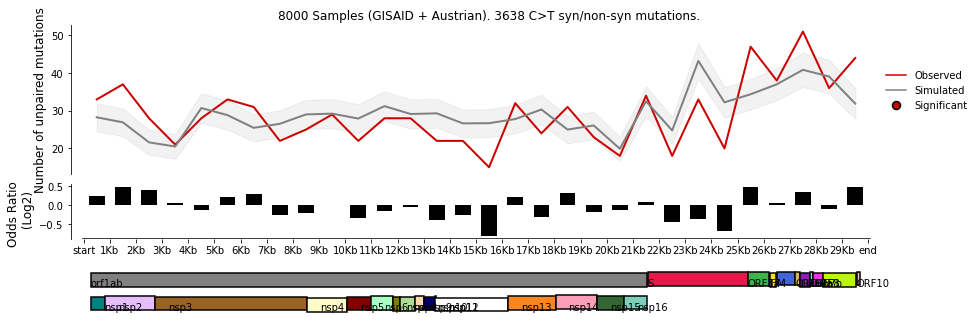

In [25]:
fig, ax = plt.subplots(figsize=(15, 5.5))
gs = gridspec.GridSpec(figure=fig, ncols=1, nrows=5,  height_ratios=[22, 8, 4, 2, 2])
gs.update(hspace=0.2, wspace=0.00)
ax0 = plt.subplot(gs[0]) # expected vs observed
ax1 = plt.subplot(gs[1]) # odds ratio
ax_ = plt.subplot(gs[2], sharex=ax0) # empy
ax2 = plt.subplot(gs[3], sharex=ax0) # genes-draw
ax3 = plt.subplot(gs[4], sharex=ax0) # genes-draw

x=df["id_chunk"].values
y1=df["unpaired_observed"].values
y2=df["mean_simulated"].values
df_sig = df[df["pvalue"]<0.01]
# Observed
ax0.plot(y1,color="#cc0000",lw=2)
x_sig = df_sig["id_chunk"].values
y_sig = df_sig["unpaired_observed"].values
ax0.scatter(x=x_sig,y=y_sig,color="#cc0000",s=50,lw=1.5,edgecolor="black")
ax0.set_ylabel("Number of unpaired mutations",fontsize=12)
# Simulated
ax0.plot(y2,color="grey",lw=2.)
# Confidence internals
y_low =[y2[i] - v for i,v in enumerate(df["stdev"].values)]
y_high =[y2[i] + v for i,v in enumerate(df["stdev"].values)]
ax0.fill_between(x,y_low,y_high,color="grey",alpha=0.1)
# barplots oddsratio
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylabel("Odds Ratio \n (Log2)",fontsize=12)
ax1.bar(x=x,height=df["log_odds_ratio"].values,color="black",width=0.6)

j=0
for i,r in df_annotations_total.sort_values("start").iterrows():
    rect = patches.Rectangle(xy=(r["start"]/1000-.5,ax2.get_ylim()[1]+random.uniform(-0.1,0.1)),width=(r["end"]-r["start"]+1)/1000,height=1,linewidth=1.5,facecolor=colors[j], clip_on=False, edgecolor="black")
    ax2.add_patch(rect)
    ax2.annotate(xy=(r["start"]/1000-.5,ax2.get_ylim()[1]),s=r["gene"])
    j+=1
    

for i,r in df_annotations[df_annotations["gene"].str.contains("nsp")].iterrows():
    rect = patches.Rectangle(xy=(r["start"]/1000-0.5,ax2.get_ylim()[1]+random.uniform(-0.1,0.1)),width=(r["end"]-r["start"]+1)/1000,height=1,linewidth=1.5,facecolor=colors[j], clip_on=False, edgecolor="black")
    ax3.add_patch(rect)
    ax3.annotate(xy=(r["start"]/1000,ax2.get_ylim()[1]),s=r["gene"])
    j+=1
    
_=ax1.set_xticks([v-0.5 for v in x]+[x[-1]+0.5])
_=ax1.set_xticklabels(["start"]+[str(v)+"Kb" for v in x[1:]]+["end"])
max_odd = np.nanmax(df["odds_ratio"].values) + 0.1
#ax1.set_ylim(-max_odd,max_odd)
ax2.set_xlabel("chunk number")
ax2.set_ylabel("number of unpaired mutations")
legend_elements = [Line2D([0], [0],  color='#cc0000', label='Observed',
                          markerfacecolor="#cc0000", markersize=10),
                   Line2D([0], [0],  color='grey', label='Simulated',
                          markerfacecolor='grey', markersize=10),
                  Line2D([0], [0],  color='white', label='Significant', markeredgewidth=1.5, markeredgecolor="black",
                          markerfacecolor='#cc0000', markersize=8, marker="o")]

# Create the figure
ax0.legend(handles=legend_elements, loc=(0.97,0.4),frameon=False)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

ax2.axis('off')
ax_.axis('off')
ax3.axis('off')
ax1.set_xlim(-1,31)
ax1.axhline(ax1.get_ylim()[0],xmin=0.015,xmax=0.955,lw=1.5,color="black")
ax2.set_xlim(-1,31)
ax3.set_xlim(-1,31)
ax0.set_xlim(-1,31)
ax0.set_xticks([])
ax0.set_title("8000 Samples (GISAID + Austrian). 3638 C>T syn/non-syn mutations.")
#ax0.set_title("8000 Samples (GISAID + Austrian). 3638 C>T syn/non-syn mutations.")
#plt.savefig(f'1k.pdf', dpi=800,bbox_inches="tight")
plt.show()